<a href="https://colab.research.google.com/github/R-Jin/bird-song-classifier/blob/main/bird_song_classifier_top_10_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset location

In [121]:
from google.colab import drive

# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Setup target directory
target_dir = "/content/drive/MyDrive/birdclef-2025"

Mounted at /content/drive


# Imports

In [122]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import librosa.display
import re
import numpy as np

# Constants

In [123]:
BATCH_SIZE = 64

SAMPLE_RATE = 32000
HOP_LENGTH = 512

# Some unwanted song type labels... may use later (Filter out unwanted labels, e.g. "frog", and combine labels with similar names)


In [124]:
unwanted_labels = [
    'uncertain', 'frog', 'frogs', 'car', 'plane', 'wind', 'river', 'surf',
    'motor', 'insect', 'noise', 'background', 'voices', 'human', 'dog',
    'perro', 'cow', 'latido', 'engine', 'traffic', 'urban', 'música',
    'music', 'unknown', 'no idea', '?', 'nao', 'não', 'environmental',
    'ambient', 'dogs', 'bird in h', 'laughing', 'hits', 'chatter', 'mechanical', 'imitation',
    'river in background', 'human voices', 'car noises', 'frogs and insects'
]

canonical_labels = {
    'song': ['song', 'songs', 'full song', 'complete song', 'alternate song', 'display song', 'morning song', 'evening song', 'day song', 'dawn song', 'vesper song', 'nuptial song', 'predawn song'],
    'call': ['call', 'calls', 'typical call', 'short call', 'long call', 'flight call', 'begging call', 'alarm call', 'chase call', 'contact call', 'feeding call', 'distress call', 'display call', 'excited call', 'juvenile call'],
    'alarm call': ['alarm call', 'alarm calls', 'alarm', 'alarm whistle', 'alarm call?', 'alarm call in flight'],
    'flight call': ['flight call', 'calls in flight', 'call in flight', 'flight calls', 'take-off calls', 'take-off call'],
    'duet': ['duet', 'duet song', 'duet call', 'couple duet', 'song and duet', 'duetting'],
    'drum': ['drum', 'drumming', 'bill snap', 'bill snapping', 'wing beat', 'wing flaps', 'wing noise', 'wing flutter', 'wing flutters', 'wing sounds', 'wing whirr', 'wing whirrs', 'wing snaps', 'bill/wing snapping'],
    'subsong': ['subsong', 'subsong?', '"subsong"'],
    'trill': ['trill', 'trilled call', 'trill call', 'cooing trill'],
    'display': ['display', 'display song', 'display call', 'song during display flight', 'display song & instrumental wings noise'],
}


# Read and clean data

In [125]:
# Only necessary for cleaning
#unwanted_labels = ['aberrant', 'perched', 'bill snaps', 'rattle', 'scold', 'snap', 'chatter', 'mechanical sounds', 'wind', 'lekking', 'lek', 'grunts', 'tapping', 'mechanical', 'voces humanas', 'immature', 'roll-snap', 'bill/wing snapping', 'estridulación', 'frogs', 'bill rattle']

label_map = {
    'song' : 'song',
    '' : 'unknown', #?????
    'call' : 'call',
    'flight call' : 'flight call',
    'alarm call' : 'alarm call',
    'duet' : 'duet',
    'calls' : 'call',
    'dawn song' : 'song', # ?
    'uncertain' : 'unknown', #?????
    'begging call' : 'begging call',
    'drumming' : 'drumming',
    'subsong' : 'subsong',
    'canto' : 'song',
    'flight calls' : 'flight call',
    'nocturnal flight call' : 'flight call', # ?
    # aberrant?
    'chamado' : 'call',
    'advertisement call' : 'call', # call?
    'hatchling or nestling' : 'hatchling or nestling',
    'interaction calls' : 'call', # call?
    'songs' : 'song',
    '?' : 'unknown',
    'song?' : 'song',
    'chorus' : 'song', # ?
    'alarm calls' : 'alarm call',
    'wing sound' : 'wing sound',
    'long song' : 'song',
    'imitation' : 'imitation',
    'wing sounds' : 'wing sound',
    'wing beats' : 'wing sound',
    'wing noise' : 'wing sound',
    # lekking?
    'display song' : 'song', # ?
    # perched?
    'excited calls' : 'call', #?
    # bill snaps?
    'morning song' : 'song', # ?
    'chase calls' : 'call', # ?
    'wing whirrs' : 'wing sound',
    # rattle?
    'alarm' : 'alarm call',
    'drum' : 'drumming',
    'wing snaps' : 'wing sound',
    'dueto' : 'duet',
    'short song' : 'song',
    # scold?
    'call?' : 'call',
    'song in flight' : 'song', # ?
    'song in duet' : 'duet',
    # snap?
    'mimicry/imitation' : 'imitation',
    'flight song': 'song', # ?
    'agitated calls' : 'call', # ?
    'interaction call' : 'call',
    'alternate song' : 'song',
    'take-off and flight calls' : 'flight call',
    'calls at roost' : 'call', # ?
    # lek ?
    'half song' : 'song',
    'couple song' : 'duet', #????
    # chatter?
    'short call' : 'call',
    'typical call' : 'call',
    # mechanical sounds?
    'mimicking' : 'imitation',
    'wing beat' : 'wing sound',
    'bater de asas' : 'wing sound',
    'song a' : 'song',
    'agitated song' : 'song', #????
    'duet song' : 'duet',
    'batido de asas' : 'wing sound',
    'wing flutter' : 'wing sound',
    # wind??
    'immature calls' : 'call',
    'daytime song' : 'song', # ?
    '"call' : 'call',
    'excited song' : 'song', # ?
    'song 2' : 'song',
    'wing flaps' : 'wing sound',
    'aggressive call' : 'call',
    'territorial call' : 'call',
    'feeding call' : 'call',
    'take-off calls' : 'flight call', # ?????
    'contact calls' : 'call',
    'song during display flight' : 'song',
    'calls on perch' : 'call',
    'perched call' : 'call',
    # grunts ?
    'daytime calls' : 'call',
    'daytime call' : 'call',
    'dawn duet' : 'duet',
    'take-off call' : 'flight call', # ?????
    'calls (2 types)' : 'call',
    'perched calls' : 'call',
    # tapping ?
    # mechanical ?
    # voces humanas ?
    'agitated call' : 'call',
    'single song' : 'song',
    'distress call of a bird being handled.' : 'call',
    'nuptial song' : 'song',
    'begging calls' : 'begging call',
    # immature ?
    'vesper song' : 'song',
    'song (variation)' : 'song',
    # roll-snap ?
    'call in flight' : 'call',
    'chase call' : 'call',
    'canto de voo' : 'song',
    # estridulación ?
    # frogs ?
    # bill rattle ?
    'couple duet' : 'duet',
    'rattle calls' : 'call',

    # song while displaying.....
 }

In [126]:
train_df = pd.read_csv("/content/drive/MyDrive/birdclef-2025/train.csv")

def clean_label(label):
  results = re.findall(r"'([^']*)'", label)
  for result in results:
    result = result.lower()

    if pd.isna(label):
        return None
    label = str(label).lower().strip()
    return label_map.get(label, None)

def clean_labels(df): # Pass df as an argument
  cleaned = []
  for song_types in df['type']: # Iterate over df['type']
    results = re.findall(r"'([^']*)'", song_types)
    labels = []
    for result in results:
      # Convert to lowercase for consistency
      result = result.lower()
      #result = label_map.get(result, result)
      result = label_map.get(result, None)

      if result is not None:
        if result not in labels:
          labels.append(result)

    if len(labels) == 0:
      labels = ['unknown']

    cleaned.append(labels)
  return cleaned # Return the cleaned list
print(len(train_df))
train_df['type'] = clean_labels(train_df)
print(len(train_df))

28564
28564


In [127]:
train_df = train_df.dropna(subset=['latitude', 'longitude'])

In [128]:
TOP_N_SPECIES = 10
sample_size = 1000
samples_per_class = sample_size // TOP_N_SPECIES

# Get top-N species by frequency
top_species = train_df['primary_label'].value_counts().nlargest(TOP_N_SPECIES).index.tolist()

# Filter DataFrame
train_df = train_df[train_df['primary_label'].isin(top_species)].reset_index(drop=True)

train_df = train_df.groupby('primary_label', group_keys=False).apply(lambda x: x.sample(n=samples_per_class)).reset_index(drop=True)
train_df = train_df.sample(sample_size).reset_index(drop=True)


<ipython-input-128-45109530633f>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('primary_label', group_keys=False).apply(lambda x: x.sample(n=samples_per_class)).reset_index(drop=True)


# Calculate number of unique species and song types

In [129]:
from ast import literal_eval
# Turn secondary label to list instead of string

unique_song_types = set()
unique_bird_species = set()

for bird_species in train_df['primary_label']:
  unique_bird_species.add(bird_species)

for song_types in train_df['type']:
  for song_type in song_types:
    unique_song_types.add(song_type)

print(f"Number of unique bird species: {len(unique_bird_species)}" )
print(f"Number of unique song types: {len(unique_song_types)}")
print(unique_bird_species)
print(unique_song_types)
print(f"Number of samples: {len(train_df)}")

Number of unique bird species: 10
Number of unique song types: 10
{'trokin', 'banana', 'yeofly1', 'roahaw', 'bobfly1', 'wbwwre1', 'grekis', 'compau', 'whtdov', 'socfly1'}
{'unknown', 'begging call', 'wing sound', 'song', 'call', 'subsong', 'duet', 'drumming', 'alarm call', 'flight call'}
Number of samples: 1000


# Remap species and song type to index

In [130]:
# Maps of song types and bird species to labels
song_type_to_label = {song_type: i for i, song_type in enumerate(unique_song_types)}
bird_species_to_label = {bird_species: i for i, bird_species in enumerate(unique_bird_species)}

# One-hot encode primary, secondary and song type labels

In [131]:
import torch

def multi_hot_encode(labels, label_to_idx, num_classes):
    """Encodes multiple labels into a multi-hot vector"""
    if not isinstance(labels, list):
        labels = [labels]  # Ensure primary label is treated as list

    # Get indices for all valid labels
    indices = [label_to_idx[label] for label in labels if label in label_to_idx]

    # Create multi-hot vector
    encoded = torch.zeros(num_classes, dtype=torch.float32)
    if indices:
        encoded.scatter_(0, torch.tensor(indices), 1.0)
    return encoded

# Apply encoding to each column
train_df['primary_label_one_hot'] = train_df['primary_label'].apply(
    lambda x: multi_hot_encode(x, bird_species_to_label, len(unique_bird_species)))

train_df['secondary_labels_one_hot'] = train_df['secondary_labels'].apply(
    lambda x: multi_hot_encode(x, bird_species_to_label, len(unique_bird_species)))

train_df['type_one_hot'] = train_df['type'].apply(
    lambda x: multi_hot_encode(x, song_type_to_label, len(unique_song_types)))

# Verify output shapes
print(f"Primary label shape: {train_df['primary_label_one_hot'][0].shape}")
print(f"Secondary labels shape: {train_df['secondary_labels_one_hot'][0].shape}")
print(f"Type shape: {train_df['type_one_hot'][0].shape}")

Primary label shape: torch.Size([10])
Secondary labels shape: torch.Size([10])
Type shape: torch.Size([10])


# Make column for position
---
Format is (latitude, longitude)

In [132]:
train_df['pos'] = list(zip(train_df['latitude'], train_df['longitude']))


In [133]:
import h5py
import numpy as np
from pathlib import Path

def load_spectrogram_h5(h5_path):
    """
    Load spectrogram data from HDF5 file

    Args:
        h5_path: Path to .h5 file containing spectrogram

    Returns:
        numpy.ndarray: 2D spectrogram array

    Raises:
        FileNotFoundError: If file doesn't exist
        ValueError: If file is corrupt or invalid format
    """
    h5_path = Path(h5_path)

    if not h5_path.exists():
        raise FileNotFoundError(f"HDF5 file not found: {h5_path}")

    try:
        with h5py.File(h5_path, 'r') as hf:
            # Load spectrogram dataset
            spectrogram = hf['spectrogram'][:]

            # Basic validation
            if not isinstance(spectrogram, np.ndarray):
                raise ValueError("Spectrogram data is not a numpy array")
            if spectrogram.ndim != 2:
                raise ValueError(f"Expected 2D array, got {spectrogram.ndim}D")
            if np.isnan(spectrogram).any():
                raise ValueError("Spectrogram contains NaN values")

            return spectrogram

    except KeyError:
        raise ValueError("HDF5 file missing 'spectrogram' dataset")
    except Exception as e:
        raise ValueError(f"Error loading HDF5 file: {str(e)}")

In [134]:
def slice_spectrogram(spectrogram, sr=32000, chunk_seconds=5, overlap=0.5):
    hop_length = 512
    frames_per_chunk = int(chunk_seconds * sr / hop_length)  # 312 at 32kHz
    hop_frames = int(frames_per_chunk * (1 - overlap))       # 156 at 50% overlap

    n_frames = spectrogram.shape[1]
    chunks = []

    for start in range(0, n_frames - frames_per_chunk + 1, hop_frames):
        end = start + frames_per_chunk
        chunks.append(spectrogram[:, start:end])

    #print(f"Generated {len(chunks)} chunks from {n_frames * hop_length / sr:.2f}s audio")
    return chunks

In [135]:
import torch
import torch.nn.functional as F

def pad_spectrogram(mel, max_width):
    if isinstance(mel, list):
        mel = torch.tensor(mel, dtype=torch.float32)  # convert list to tensor
    elif isinstance(mel, np.ndarray):
        mel = torch.from_numpy(mel).float()           # if it's a NumPy array

    # mel: [mel_bins, time]
    if mel.shape[1] < max_width:
        pad_width = max_width - mel.shape[1]
        mel = F.pad(mel, (0, pad_width), mode='constant', value=0)
    else:
        mel = mel[:, :max_width]
    return mel


In [136]:
split_in_seconds = 15
max_width = split_in_seconds * SAMPLE_RATE // HOP_LENGTH

def change_extension_to_h5(filename):
    """Change file extension from .ogg to .h5"""
    base = os.path.splitext(filename)[0]  # Get filename without extension
    return base + '.h5'  # Add .h5 extension

class BirdClefDataset(Dataset):
    def __init__(self, df, target_dir, audio_transform=None, max_width=max_width):
        self.df = df
        self.target_dir = target_dir
        self.audio_transform = audio_transform
        self.max_width = max_width

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        return:
          mel:       Spectogram chunks
          primary:   Primary species label one-hot (only one)
          secondary: Secondary species label one-hot (multiple)
          type:      Song type onehot
          pos:       Position of recording in (latitude, longitude)
        """
        row = self.df.iloc[idx]
        filename = row["filename"]
        species, filename = filename.split("/")
        filename = change_extension_to_h5(filename)

        spectogram = os.path.join(self.target_dir, "train_spectrograms", species, filename)

        # Load spectrogram
        mel = load_spectrogram_h5(spectogram)
        chunks = slice_spectrogram(mel)
        if len(chunks) == 0:
            chunk = pad_spectrogram(mel, self.max_width)
            chunks = [chunk]

        chunks = [pad_spectrogram(chunk, self.max_width) for chunk in chunks]        # Apply audio transform
        chunks = torch.stack(chunks)  # Convert list → tensor: [N_chunks, mel_bins, time]

        # labels

        primary = row["primary_label_one_hot"]
        secondary = row["secondary_labels_one_hot"]
        song_type = row["type_one_hot"]
        pos = row["pos"]

        primary = primary.clone().detach()
        song_type = song_type.clone().detach()
        pos = torch.tensor(pos, dtype=torch.float32)

        return chunks, primary, song_type, pos

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
val_dataset = BirdClefDataset(val_df, target_dir, max_width=max_width)
train_dataset = BirdClefDataset(train_df, target_dir)

In [137]:
sample = train_dataset[0]
sample

(tensor([[[-77.9510, -44.9678, -38.2330,  ...,   0.0000,   0.0000,   0.0000],
          [-77.0556, -44.9755, -34.8378,  ...,   0.0000,   0.0000,   0.0000],
          [-78.2797, -50.2456, -41.3816,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [-80.0000, -60.6602, -54.0683,  ...,   0.0000,   0.0000,   0.0000],
          [-80.0000, -61.3213, -57.1995,  ...,   0.0000,   0.0000,   0.0000],
          [-80.0000, -67.3831, -56.4218,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[-52.3345, -48.9863, -44.5258,  ...,   0.0000,   0.0000,   0.0000],
          [-38.1167, -37.0272, -41.8713,  ...,   0.0000,   0.0000,   0.0000],
          [-38.4341, -35.1506, -32.8620,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [-53.9844, -51.0757, -49.4870,  ...,   0.0000,   0.0000,   0.0000],
          [-56.3121, -59.5655, -58.4470,  ...,   0.0000,   0.0000,   0.0000],
          [-56.2035, -56.2659, -55.1153,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[-40.0869, -43.700

# Create batches where all the primary labels are the same

In [138]:
species_to_indices = {}
for idx, row in train_df.iterrows():
    species = row['primary_label']
    if species not in species_to_indices:
        species_to_indices[species] = []
    species_to_indices[species].append(idx)

In [139]:
from torch.utils.data import DataLoader

def simple_collate_fn(batch):
    chunk_lists, primary_list, type_list, pos_list = zip(*batch)

    max_chunks = 4  # reduce memory usage
    padded_chunks = []
    for chunks in chunk_lists:
        chunks = random.sample(chunks, k=min(max_chunks, len(chunks)))
        pad_amt = max_chunks - chunks.shape[0]
        if pad_amt > 0:
            pad = torch.zeros((pad_amt, *chunks.shape[1:]))
            chunks = torch.cat([chunks, pad], dim=0)
        padded_chunks.append(chunks)

    mel = torch.stack(padded_chunks).unsqueeze(2)  # [B, max_chunks, 1, mel_bins, time]
    primary = torch.stack(primary_list)
    song_type = torch.stack(type_list)
    pos = torch.stack(pos_list)

    return mel, primary, song_type, pos

train_loader = DataLoader(
    train_dataset,
    batch_size=2,         # small batch
    shuffle=True,
    collate_fn=simple_collate_fn,
    num_workers=0,        # critical for low RAM
    pin_memory=False
)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=simple_collate_fn, num_workers=0)

# Model

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Head(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class JPM(nn.Module):
    def __init__(self, in_dim, s_dim, t_dim):
        super(JPM, self).__init__()
        z_dim = 256
        c_dim = 2  # latitude and longitude

        # Shared convolutional backbone (Net_Z(X))
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(128, z_dim)  # assuming input is pre-scaled so output size is 128
        )

        # Independent predictions
        self.indep_s = Head(z_dim, s_dim)  # species (classification)
        self.indep_t = Head(z_dim, t_dim)  # song type (classification)
        self.indep_c = Head(z_dim, c_dim)  # coordinates (regression)

        # Joint predictions 1
        self.joint_ts = Head(z_dim + t_dim, s_dim)
        self.joint_cs = Head(z_dim + c_dim, s_dim)

        self.joint_st = Head(z_dim + s_dim, t_dim)
        self.joint_ct = Head(z_dim + c_dim, t_dim)

        self.joint_sc = Head(z_dim + s_dim, c_dim)
        self.joint_tc = Head(z_dim + t_dim, c_dim)

        # Joint predictions 2
        self.joint_tcs = Head(z_dim + t_dim + c_dim, s_dim)
        self.joint_cts = Head(z_dim + c_dim + t_dim, s_dim)

        self.joint_sct = Head(z_dim + s_dim + c_dim, t_dim)
        self.joint_cst = Head(z_dim + c_dim + s_dim, t_dim)

        self.joint_stc = Head(z_dim + s_dim + t_dim, c_dim)
        self.joint_tsc = Head(z_dim + t_dim + s_dim, c_dim)

    def forward(self, x, y_s=None, y_t=None, y_c=None):
        z = self.backbone(x)

        # Independent predictions
        s = self.indep_s(z)
        t = self.indep_t(z)
        c = self.indep_c(z)

        # Inference case
        if y_s is None:
            y_s = s.detach()
            y_t = t.detach()
            y_c = c.detach()

        # y_s = F.one_hot(y_s.argmax(dim=-1), num_classes=s.shape[-1]).float()
        # y_t = F.one_hot(y_t.argmax(dim=-1), num_classes=t.shape[-1]).float()

        y_s = F.one_hot(y_s, num_classes=s.shape[-1]).float()
        y_t = F.one_hot(y_t, num_classes=t.shape[-1]).float()

        # Note: y_c is already continuous, do not one-hot

        zs = torch.cat([z, y_s], dim=1)
        zt = torch.cat([z, y_t], dim=1)
        zc = torch.cat([z, y_c], dim=1)

        # Joint 1
        ts = self.joint_ts(zt)
        cs = self.joint_cs(zc)
        st = self.joint_st(zs)
        ct = self.joint_ct(zc)
        sc = self.joint_sc(zs)
        tc = self.joint_tc(zt)

        # For inference: optional second-stage values
        if y_s is None:
            y_s2 = ts.detach()
            y_s3 = cs.detach()
            y_t2 = st.detach()
            y_t3 = ct.detach()
            y_c2 = sc.detach()
            y_c3 = tc.detach()
        else:
            y_s2 = ts
            y_s3 = cs
            y_t2 = st
            y_t3 = ct
            y_c2 = sc
            y_c3 = tc

        zts = torch.cat([z, y_t, y_s2], dim=1)
        zcs = torch.cat([z, y_c, y_s3], dim=1)
        zst = torch.cat([z, y_s, y_t2], dim=1)
        zct = torch.cat([z, y_c, y_t3], dim=1)
        zsc = torch.cat([z, y_s, y_c2], dim=1)
        ztc = torch.cat([z, y_t, y_c3], dim=1)

        # Joint 2
        tcs = self.joint_tcs(zct)
        cts = self.joint_cts(zct)
        sct = self.joint_sct(zsc)
        cst = self.joint_cst(zsc)
        stc = self.joint_stc(zst)
        tsc = self.joint_tsc(zst)

        s_logits = [s, ts, cs, tcs, cts]
        t_logits = [t, st, ct, sct, cst]
        c_preds = [c, sc, tc, stc, tsc]  # Continuous [lat, lon]

        return s_logits, t_logits, c_preds


In [141]:
from sklearn.metrics import precision_score
import torch.nn.functional as F

def evaluate(model, val_loader, device):
    model.eval()
    y_true_species = []
    y_pred_species = []
    y_true_type = []
    y_pred_type = []
    mse_total = 0.0
    total_samples = 0

    with torch.no_grad():
        for mel, primary, song_type, pos in val_loader:
            B, N_chunks, C, H, W = mel.shape
            mel = mel.view(B * N_chunks, C, H, W).to(device)

            # Get labels per recording
            y_s = primary.argmax(dim=1).to(device)
            y_t = song_type.argmax(dim=1).to(device)
            y_c = pos.to(device)

            # Repeat labels per chunk for model input
            y_s_repeated = y_s.repeat_interleave(N_chunks)
            y_t_repeated = y_t.repeat_interleave(N_chunks)
            y_c_repeated = y_c.repeat_interleave(N_chunks, dim=0)

            # Forward pass
            s_logits, t_logits, c_preds = model(mel, y_s_repeated, y_t_repeated, y_c_repeated)

            # Aggregate logits across chunks
            s_main = s_logits[0].view(B, N_chunks, -1).mean(dim=1)
            t_main = t_logits[0].view(B, N_chunks, -1).mean(dim=1)
            c_main = c_preds[0].view(B, N_chunks, -1).mean(dim=1)

            # Store predictions and labels for metrics
            y_true_species.extend(y_s.cpu().numpy())
            y_pred_species.extend(s_main.argmax(dim=1).cpu().numpy())
            y_true_type.extend(y_t.cpu().numpy())
            y_pred_type.extend(t_main.argmax(dim=1).cpu().numpy())

            mse_total += F.mse_loss(c_main, y_c, reduction='sum').item()
            total_samples += B

    precision_species = precision_score(y_true_species, y_pred_species, average='macro', zero_division=0)
    precision_type = precision_score(y_true_type, y_pred_type, average='macro', zero_division=0)
    mse_coord = mse_total / total_samples

    print(f"🔍 Val Precision — Species: {precision_species:.3f} | Type: {precision_type:.3f} | Coord MSE: {mse_coord:.4f}")
    model.train()
    return (
        precision_species, precision_type, mse_coord,
        y_true_species, y_pred_species,
        y_true_type, y_pred_type
    )


In [142]:
train_losses = []
val_precisions_species = []
val_precisions_type = []
val_mse_coords = []


In [143]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = JPM(
    in_dim=1,
    s_dim=len(bird_species_to_label),
    t_dim=len(song_type_to_label),
).to(device)

# Loss functions
ce_loss = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for mel, primary, song_type, pos in loop:
        B, N_chunks, C, H, W = mel.shape
        mel = mel.view(B * N_chunks, C, H, W).to(device)

        y_s = torch.argmax(primary, dim=1).to(device)
        y_t = torch.argmax(song_type, dim=1).to(device)
        y_c = pos.to(device)

        y_s_repeated = y_s.repeat_interleave(N_chunks)
        y_t_repeated = y_t.repeat_interleave(N_chunks)
        y_c_repeated = y_c.repeat_interleave(N_chunks, dim=0)

        s_logits, t_logits, c_preds = model(mel, y_s_repeated, y_t_repeated, y_c_repeated)

        s_logit_main = s_logits[0].view(B, N_chunks, -1).mean(dim=1)
        t_logit_main = t_logits[0].view(B, N_chunks, -1).mean(dim=1)
        c_pred_main = c_preds[0].view(B, N_chunks, -1).mean(dim=1)

        loss_s = ce_loss(s_logit_main, y_s)
        loss_t = ce_loss(t_logit_main, y_t)
        loss_c = mse_loss(c_pred_main, y_c)

        loss = 1.5 * loss_s + loss_t + 0.5 * loss_c

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    train_losses.append(avg_loss)

    # Get all evaluation results
    precision_s, precision_t, mse_c, y_true_s, y_pred_s, y_true_t, y_pred_t = evaluate(model, val_loader, device)
    val_precisions_species.append(precision_s)
    val_precisions_type.append(precision_t)
    val_mse_coords.append(mse_c)


Epoch 1/10 — Avg Loss: 245.8520
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 831.0558


Epoch 2/10 — Avg Loss: 188.1870
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 774.3435


Epoch 3/10 — Avg Loss: 183.8079
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 831.1923


Epoch 4/10 — Avg Loss: 187.1503
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 790.2726


Epoch 5/10 — Avg Loss: 185.2362
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 850.8721


Epoch 6/10 — Avg Loss: 185.0824
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 772.0672


Epoch 7/10 — Avg Loss: 185.5222
🔍 Val Precision — Species: 0.003 | Type: 0.085 | Coord MSE: 1114.0303


Epoch 8/10 — Avg Loss: 184.8845
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 785.9467


Epoch 9/10 — Avg Loss: 175.5860
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 1292.6483


Epoch 10/10 — Avg Loss: 185.5672
🔍 Val Precision — Species: 0.003 | Type: 0.110 | Coord MSE: 908.6921


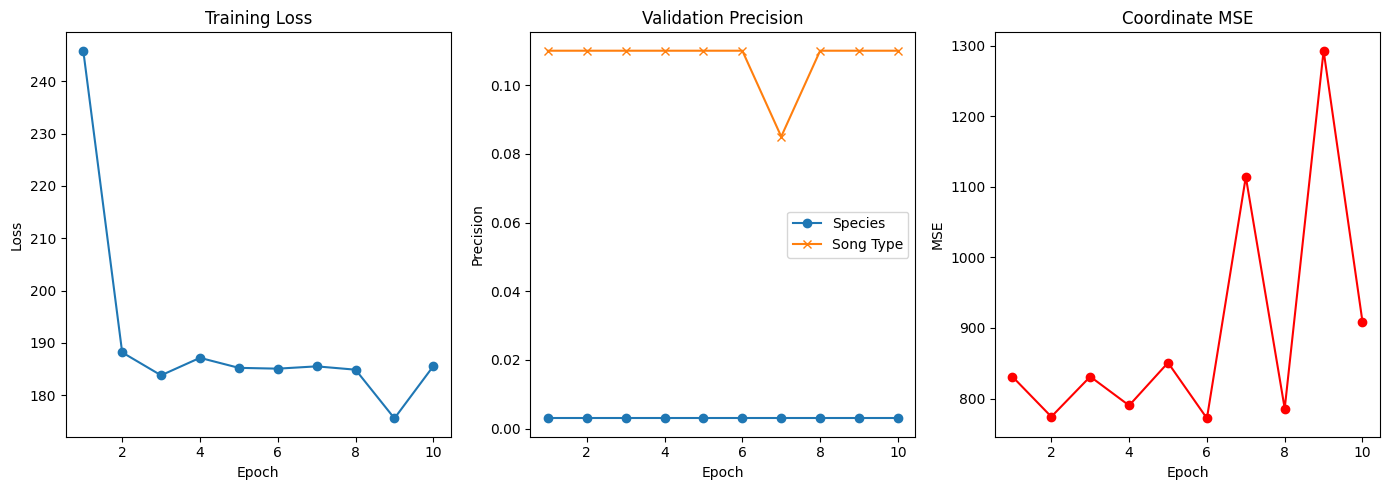

<Figure size 800x600 with 0 Axes>

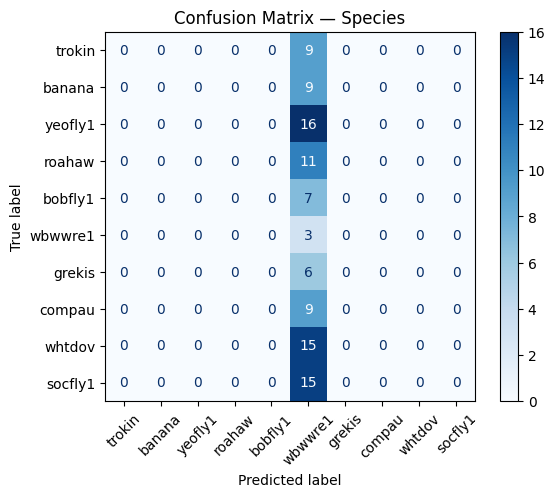

<Figure size 800x600 with 0 Axes>

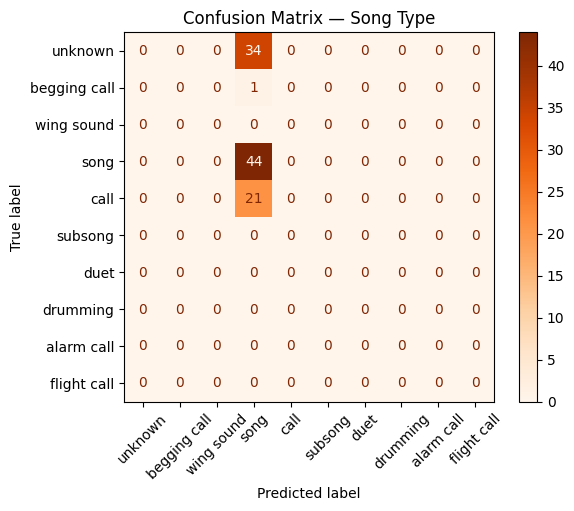

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot training metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Precision
plt.subplot(1, 3, 2)
plt.plot(epochs, val_precisions_species, marker='o', label='Species')
plt.plot(epochs, val_precisions_type, marker='x', label='Song Type')
plt.title("Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

# Coord MSE
plt.subplot(1, 3, 3)
plt.plot(epochs, val_mse_coords, marker='o', color='red')
plt.title("Coordinate MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.tight_layout()
plt.show()

# Confusion Matrix — Species
species_classes = list(bird_species_to_label.keys())
species_labels = list(range(len(species_classes)))

cm_species = confusion_matrix(y_true_s, y_pred_s, labels=species_labels)
disp_species = ConfusionMatrixDisplay(confusion_matrix=cm_species, display_labels=species_classes)
plt.figure(figsize=(8, 6))
disp_species.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix — Species")
plt.show()

# Confusion Matrix — Song Type
type_classes = list(song_type_to_label.keys())
type_labels = list(range(len(type_classes)))

cm_type = confusion_matrix(y_true_t, y_pred_t, labels=type_labels)
disp_type = ConfusionMatrixDisplay(confusion_matrix=cm_type, display_labels=type_classes)
plt.figure(figsize=(8, 6))
disp_type.plot(xticks_rotation=45, cmap='Oranges')
plt.title("Confusion Matrix — Song Type")
plt.show()


